In [1]:
import os
import time
import random
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import transforms, datasets
import torchvision.models as models
import timm
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torch.utils.data import DataLoader, random_split, Subset, Dataset
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
)
from sklearn.preprocessing import label_binarize
from tqdm import tqdm
import gc


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Modified FilteredImageDataset class with Pterygium filtering
class FilteredImageDataset(Dataset):
    def __init__(self, dataset, excluded_classes=None):
        """
        Create a filtered dataset that excludes specific classes.
        
        Args:
            dataset: Original dataset (ImageFolder or similar)
            excluded_classes: List of class names to exclude (e.g., ["Pterygium"])
        """
        self.dataset = dataset
        self.excluded_classes = excluded_classes or []
        
        # Get original class information
        self.orig_classes = dataset.classes
        self.orig_class_to_idx = dataset.class_to_idx
        
        # Create indices of samples to keep (excluding specified classes)
        self.indices = []
        for idx, (_, target) in enumerate(dataset.samples):
            class_name = self.orig_classes[target]
            if class_name not in self.excluded_classes:
                self.indices.append(idx)
        
        # Create new class mapping without excluded classes
        remaining_classes = [c for c in self.orig_classes if c not in self.excluded_classes]
        self.classes = remaining_classes
        self.class_to_idx = {cls: idx for idx, cls in enumerate(remaining_classes)}
        self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}
        
        # Create a mapping from old indices to new indices
        self.target_mapping = {}
        for old_class, old_idx in self.orig_class_to_idx.items():
            if old_class in self.class_to_idx:
                self.target_mapping[old_idx] = self.class_to_idx[old_class]
        
        print(f"Filtered out classes: {self.excluded_classes}")
        print(f"Remaining classes: {self.classes}")
        print(f"Original dataset size: {len(dataset)}, Filtered dataset size: {len(self.indices)}")

    def __getitem__(self, index):
        """Get item from the filtered dataset with remapped class labels."""
        orig_idx = self.indices[index]
        img, old_target = self.dataset[orig_idx]
        
        # Remap target to new class index
        new_target = self.target_mapping[old_target]
        
        return img, new_target

    def __len__(self):
        """Return the number of samples in the filtered dataset."""
        return len(self.indices)
    
    # Allow transform to be updated
    def set_transform(self, transform):
        """Update the transform for the dataset."""
        self.dataset.transform = transform

# Model Definition

In [3]:
# Early stopping class
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        score = -val_loss
        
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

# Model architecture functions
def _get_feature_blocks(model):
    """
    Utility: locate the main feature blocks container in a timm model.
    Returns a list-like module of blocks.
    """
    for attr in ('features', 'blocks', 'layers', 'stem'):  # common container names
        if hasattr(model, attr):
            return getattr(model, attr)
    # fallback: collect all children except classifier/head
    return list(model.children())[:-1]

def _freeze_except_last_n(blocks, n):
    total = len(blocks)
    for idx, block in enumerate(blocks):
        requires = (idx >= total - n)
        for p in block.parameters():
            p.requires_grad = requires

def get_model_mobilenetv4(num_classes, freeze_layers=True, device='cuda'):
    model = timm.create_model('mobilenetv4_conv_medium.e500_r256_in1k', pretrained=True)
    if freeze_layers:
        blocks = _get_feature_blocks(model)
        _freeze_except_last_n(blocks, 2)
    # replace classifier
    in_features = model.classifier.in_features
    model.classifier = nn.Sequential(
        nn.Linear(in_features, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.4),
        nn.Linear(512, num_classes)
    )
    return model.to(device)

def get_model_levit(num_classes, freeze_layers=True, device='cuda'):
    model = timm.create_model('levit_128s.fb_dist_in1k', pretrained=True)
    if freeze_layers:
        blocks = _get_feature_blocks(model)
        _freeze_except_last_n(blocks, 2)
    # Attempt to extract in_features from model.head or classifier
    head = getattr(model, 'head_dist', None) or getattr(model, 'classifier', None)
    linear = getattr(head, 'linear')
    in_features = 384
    model.head = nn.Sequential(
        nn.Linear(in_features, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.4),
        nn.Linear(512, num_classes)
    )
    model.head_dist = nn.Sequential(
        nn.Linear(in_features, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.4),
        nn.Linear(512, num_classes)
    )
    return model.to(device)

def get_model_efficientvit(num_classes, freeze_layers=True, device='cuda'):
    model = timm.create_model('efficientvit_m1.r224_in1k', pretrained=True)
    if freeze_layers:
        blocks = _get_feature_blocks(model)
        _freeze_except_last_n(blocks, 2)
    # handle different head naming
    head = getattr(model, 'head', None)
    print(head)
    linear = getattr(head, 'linear')
    in_features = 192
    model.head.linear = nn.Sequential(
        nn.Linear(in_features, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.4),
        nn.Linear(512, num_classes)
    )
    return model.to(device)
    
def get_model_gernet(num_classes, freeze_layers=True, device='cuda'):
    """
    Load and configure a GENet (General and Efficient Network) model with customizable classifier.
    
    Args:
        num_classes: Number of output classes
        freeze_layers: If True, freeze all but the last 2 blocks
        device: Device to load the model on ('cuda' or 'cpu')
        
    Returns:
        Configured GENet model
    """
    model = timm.create_model('gernet_s.idstcv_in1k', pretrained=True)
    
    if freeze_layers:
        # For GENet, we need to specifically handle its structure
        # It typically has a 'stem' and 'stages' structure
        if hasattr(model, 'stem') and hasattr(model, 'stages'):
            # Freeze stem completely
            for param in model.stem.parameters():
                param.requires_grad = False
                
            # Freeze all stages except the last two
            stages = list(model.stages.children())
            total_stages = len(stages)
            for i, stage in enumerate(stages):
                requires_grad = (i >= total_stages - 2)
                for param in stage.parameters():
                    param.requires_grad = requires_grad
        else:
            # Fallback to generic approach
            blocks = _get_feature_blocks(model)
            _freeze_except_last_n(blocks, 2)
    
    # Replace classifier
    in_features = model.head.fc.in_features
    model.head.fc = nn.Sequential(
        nn.Linear(in_features, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.4),
        nn.Linear(512, num_classes)
    )
    return model.to(device)

def get_model_regnetx(num_classes, freeze_layers=True, device='cuda'):
    """
    Load and configure a RegNetX model with customizable classifier.
    
    Args:
        num_classes: Number of output classes
        freeze_layers: If True, freeze all but the last 2 blocks
        device: Device to load the model on ('cuda' or 'cpu')
        
    Returns:
        Configured RegNetX model
    """
    model = timm.create_model('regnetx_008.tv2_in1k', pretrained=True)
    
    if freeze_layers:
        # Looking at the error, we need to inspect the model structure carefully
        # Print the model structure to understand it better in real use
        # print(model)
        
        # Direct approach: check the model structure and freeze components individually
        # First, freeze all parameters
        for param in model.parameters():
            param.requires_grad = False
            
        # Then unfreeze the last few layers manually based on RegNetX structure
        # RegNetX typically has 'stem' + 'trunk' structure in timm
        if hasattr(model, 'trunk'):
            # Unfreeze final stages of the trunk
            trunk_blocks = list(model.trunk.children())
            # Unfreeze approximately last 25% of trunk blocks
            unfreeze_from = max(0, int(len(trunk_blocks) * 0.75))
            for i in range(unfreeze_from, len(trunk_blocks)):
                for param in trunk_blocks[i].parameters():
                    param.requires_grad = True
        
        # Always unfreeze the classifier/head for fine-tuning
        for param in model.head.parameters():
            param.requires_grad = True
    
    # Replace classifier
    in_features = model.head.fc.in_features
    model.head.fc = nn.Sequential(
        nn.Linear(in_features, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.4),
        nn.Linear(512, num_classes)
    )
    return model.to(device)

# Training function

In [4]:
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, early_stopping, epochs=15, use_ddp=False):
    """
    Train the model and perform validation using multiple GPUs.
    Supports both DataParallel (DP) and DistributedDataParallel (DDP) modes.
    
    Args:
        model: Model to train
        criterion: Loss function
        optimizer: Optimizer for training
        scheduler: Learning rate scheduler
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        early_stopping: Early stopping handler
        epochs: Maximum number of epochs to train
        use_ddp: Whether to use DistributedDataParallel (True) or DataParallel (False)
    """
    # Check available GPUs
    num_gpus = torch.cuda.device_count()
    if num_gpus < 2:
        print(f"Warning: Requested multi-GPU training but only {num_gpus} GPU(s) available. Continuing with available resources.")
    else:
        print(f"Using {num_gpus} GPUs for training")
    
    # Setup device and model
    if num_gpus >= 2:
        if use_ddp:
            # For DistributedDataParallel
            import torch.distributed as dist
            from torch.nn.parallel import DistributedDataParallel as DDP
            
            # Initialize process group
            dist.init_process_group(backend='nccl')
            local_rank = dist.get_rank()
            torch.cuda.set_device(local_rank)
            device = torch.device(f"cuda:{local_rank}")
            
            model = model.to(device)
            model = DDP(model, device_ids=[local_rank])
        else:
            # For DataParallel (simpler to use)
            device = torch.device("cuda:0")
            model = model.to(device)
            model = torch.nn.DataParallel(model)
    else:
        # Single GPU
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    # Store validation predictions and labels for final evaluation
    all_val_labels = []
    all_val_preds = []
    all_val_scores = []
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = correct / total
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        all_labels = []
        all_preds = []
        all_scores = []
        
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item() * inputs.size(0)
                probs = F.softmax(outputs, dim=1)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                all_labels.extend(labels.cpu().numpy().tolist())
                all_preds.extend(predicted.cpu().numpy().tolist())
                all_scores.append(probs.cpu().numpy())
        
        epoch_val_loss = running_loss / len(val_loader.dataset)
        epoch_val_acc = correct / total
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)
        
        all_scores = np.vstack(all_scores) if all_scores else np.array([])
        
        # Store validation results for the final epoch
        all_val_labels = all_labels
        all_val_preds = all_preds
        all_val_scores = all_scores
        
        # Update learning rate scheduler
        scheduler.step(epoch_val_loss)
        
        print(f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}")
        print(f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")
        print(f"Learning rate: {optimizer.param_groups[0]['lr']:.6f}")
        
        # Check early stopping
        early_stopping(epoch_val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered!")
            break
            
        # Free up memory
        del all_labels, all_preds, all_scores
        gc.collect()
        torch.cuda.empty_cache()
    
    # Clean up DDP if used
    if num_gpus >= 2 and use_ddp:
        dist.destroy_process_group()
    
    return model, train_losses, val_losses, train_accs, val_accs, all_val_labels, all_val_preds, all_val_scores


# Evaluation plotting functions

In [5]:
def plot_roc_curves(y_true, y_scores, class_names):
    """
    Plot ROC curves for multi-class classification.
    
    Parameters:
    - y_true: true labels
    - y_scores: predicted probability scores from model
    - class_names: list of class names
    """
    # Ensure inputs are numpy arrays
    if torch.is_tensor(y_true):
        y_true = y_true.cpu().numpy()
    if torch.is_tensor(y_scores):
        y_scores = y_scores.cpu().numpy()
    
    n_classes = len(class_names)
    
    # Binarize the labels for one-vs-rest ROC calculation
    y_true_bin = label_binarize(y_true, classes=range(n_classes))
    
    # Compute ROC curve and ROC area for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    plt.figure(figsize=(12, 8))
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f'{class_names[i]} (area = {roc_auc[i]:.2f})')
    
    # Plot the diagonal (random classifier)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    
    # Calculate and plot micro-average ROC curve
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_scores.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    plt.plot(fpr["micro"], tpr["micro"], 
             label=f'Micro-average (area = {roc_auc["micro"]:.2f})', 
             lw=2, linestyle=':', color='deeppink')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Return the AUC values for reporting
    return roc_auc

def plot_pr_curves(y_true, y_scores, class_names):
    """
    Plot Precision-Recall curves for multi-class classification.
    
    Parameters:
    - y_true: true labels
    - y_scores: predicted probability scores from model
    - class_names: list of class names
    """
    # Ensure inputs are numpy arrays
    if torch.is_tensor(y_true):
        y_true = y_true.cpu().numpy()
    if torch.is_tensor(y_scores):
        y_scores = y_scores.cpu().numpy()
    
    n_classes = len(class_names)
    
    # Binarize the labels
    y_true_bin = label_binarize(y_true, classes=range(n_classes))
    
    # Compute PR curve and average precision for each class
    precision = {}
    recall = {}
    avg_precision = {}
    
    plt.figure(figsize=(12, 8))
    
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_scores[:, i])
        avg_precision[i] = average_precision_score(y_true_bin[:, i], y_scores[:, i])
        
        plt.plot(recall[i], precision[i], lw=2,
                 label=f'{class_names[i]} (AP = {avg_precision[i]:.2f})')
    
    # Calculate and plot micro-average PR curve
    precision["micro"], recall["micro"], _ = precision_recall_curve(
        y_true_bin.ravel(), y_scores.ravel())
    avg_precision["micro"] = average_precision_score(y_true_bin.ravel(), y_scores.ravel())
    
    plt.plot(recall["micro"], precision["micro"],
             label=f'Micro-average (AP = {avg_precision["micro"]:.2f})',
             lw=2, linestyle=':', color='deeppink')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend(loc="best")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Return the average precision values for reporting
    return avg_precision

def plot_accuracy_and_loss(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12, 5))
    # Accuracy curve
    plt.subplot(1, 2, 1)
    plt.plot(train_accs, label="Train Accuracy")
    plt.plot(val_accs, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curve")
    plt.legend()
    plt.grid(True)
    
    # Loss curve
    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names):
    # Ensure we're working with numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Get unique values in both arrays
    unique_values = np.unique(np.concatenate([y_true, y_pred]))
    print(f"Unique values in confusion matrix data: {unique_values}")
    
    # Create the confusion matrix with explicit labels
    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

def plot_per_class_accuracy(y_true, y_pred, class_names):
    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Get number of expected classes
    num_classes = len(class_names)
    
    # Create the confusion matrix with explicit labels
    cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
    
    # Calculate per-class accuracy
    per_class_accuracy = np.zeros(num_classes)
    for i in range(num_classes):
        if i < cm.shape[0] and np.sum(cm[i, :]) > 0:
            per_class_accuracy[i] = cm[i, i] / np.sum(cm[i, :])
    
    # Create the bar plot
    plt.figure(figsize=(14, 7))
    plt.bar(range(num_classes), per_class_accuracy, color="skyblue")
    plt.xticks(range(num_classes), class_names, rotation=45, ha='right')
    plt.xlabel("Classes")
    plt.ylabel("Accuracy")
    plt.title("Per-Class Accuracy")
    plt.tight_layout()
    plt.show()

In [6]:
from sklearn.metrics import cohen_kappa_score

def compute_classification_metrics(y_true, y_pred, y_scores, num_classes, class_names, model_name=""):
    """
    Compute comprehensive classification metrics including ROC AUC, PR AUC, and Cohen's Kappa.
    
    Parameters:
    - y_true: true labels
    - y_pred: predicted labels
    - y_scores: predicted probability scores from model
    - num_classes: number of classes
    - class_names: list of class names
    - model_name: name of the model (for display purposes)
    
    Returns:
    - accuracy: overall accuracy score
    - report_dict: classification report as dictionary
    - roc_auc_dict: ROC AUC scores by class
    - pr_auc_dict: PR AUC scores by class
    - kappa: Cohen's Kappa score
    """
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Overall Accuracy: {accuracy:.4f}")
    
    # Calculate and display Cohen's Kappa
    kappa = cohen_kappa_score(y_true, y_pred)
    print(f"Cohen's Kappa Score: {kappa:.4f}")
    
    # Generate classification report
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    
    # Print formatted classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # Calculate ROC curves and AUC for each class
    print("\nCalculating ROC curves...")
    roc_auc_dict = plot_roc_curves(y_true, y_scores, class_names)
    
    # Calculate PR curves and AUC for each class
    print("\nCalculating PR curves...")
    pr_auc_dict = plot_pr_curves(y_true, y_scores, class_names)
    
    # Return metrics for comparison
    return accuracy, report, roc_auc_dict, pr_auc_dict, kappa

# Also update evaluate_on_test_set to include kappa
def evaluate_on_test_set(model, test_loader, dataset):
    """Evaluate a trained model on test dataset"""
    class_names = dataset.classes
    num_classes = len(class_names)
    
    model.eval()
    device = next(model.parameters()).device
    
    all_labels = []
    all_preds = []
    all_scores = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_scores.append(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())
    
    all_scores = np.vstack(all_scores)
    
    # Compute metrics including kappa
    accuracy, report_dict, roc_auc_dict, pr_auc_dict, kappa = compute_classification_metrics(
        all_labels, all_preds, all_scores, num_classes, class_names)
    
    # Build results dictionary with kappa
    results = {
        'accuracy': accuracy,
        'report': report_dict,
        'roc_auc': roc_auc_dict,
        'pr_auc': pr_auc_dict,
        'kappa': kappa
    }
    
    return results

# Main training function

In [7]:
# Update the model_train function to include kappa in the results
def model_train(model, train_loader, val_loader, dataset, epochs=20):
    model_name = type(model).__name__
    if hasattr(model, 'pretrained_cfg') and 'name' in model.pretrained_cfg:
        model_name = model.pretrained_cfg['name']
        
    print(f"\n{'='*20} Training {model_name} {'='*20}\n")
        
    class_names = dataset.classes
    num_classes = len(class_names)
    learning_rate = 0.001
    
    try:
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
        early_stopping = EarlyStopping(patience=5)
        
        model, train_losses, val_losses, train_accs, val_accs, val_labels, val_preds, val_scores = train_model(
            model, nn.CrossEntropyLoss(), optimizer, scheduler,
            train_loader, val_loader, early_stopping, epochs=epochs, use_ddp=False
        )

        print(f"Saving Model to : {type(model).__name__}.pth")
        torch.save(best_model_obj.state_dict(), f"{type(model).__name__}.pth")
        
        print(f"\n{'='*20} Evaluation for {model_name} {'='*20}\n")
        
        # Plot training curves
        plot_accuracy_and_loss(train_losses, val_losses, train_accs, val_accs)
        
        # Process validation predictions and labels
        try:
            plot_confusion_matrix(val_labels, val_preds, class_names)
            plot_per_class_accuracy(val_labels, val_preds, class_names)
            
            # Get metrics from the updated function including kappa
            accuracy, report_dict, roc_auc_dict, pr_auc_dict, kappa = compute_classification_metrics(
                val_labels, val_preds, val_scores, num_classes, class_names, model_name)
            
            # Build a results dictionary including kappa
            results = {
                'accuracy': accuracy,
                'report': report_dict,
                'roc_auc': roc_auc_dict,
                'pr_auc': pr_auc_dict,
                'kappa': kappa
            }
            
            return results
        except Exception as viz_error:
            print(f"Error in visualization: {viz_error}")
            import traceback
            traceback.print_exc()
            return {'accuracy': None}
            
    except Exception as e:
        print(f'Error occurred when training {model_name}: {e}')
        import traceback
        traceback.print_exc()
        return {'accuracy': None}
    finally:
        # Clean up memory
        if 'optimizer' in locals():
            del optimizer
        if 'scheduler' in locals():
            del scheduler
        if 'early_stopping' in locals():
            del early_stopping
        if 'train_losses' in locals():
            del train_losses
            del val_losses
            del train_accs
            del val_accs
            del val_labels
            del val_preds
            del val_scores
        
        gc.collect()
        torch.cuda.empty_cache()

# Comparison Function

In [8]:
def compare_models(models, train_loader, val_loader, test_loader, dataset, epochs=20, names=None):
    if names is None:
        names = [f"Model {i+1}" for i in range(len(models))]
    
    val_results = {}
    test_results = {}
    best_model_obj = None
    best_accuracy = -1
    best_model_name = ""
    
    # Summary dictionaries for metrics
    val_roc_auc_summary = {}
    test_roc_auc_summary = {}
    val_pr_auc_summary = {}
    test_pr_auc_summary = {}
    val_kappa_summary = {}
    test_kappa_summary = {}
    
    for i, (model, name) in enumerate(zip(models, names)):
        print(f"\n\n{'#'*30} Training {name} ({i+1}/{len(models)}) {'#'*30}\n")
        model_results = model_train(model, train_loader, val_loader, dataset, epochs)
        
        # Extract accuracy from results
        accuracy = model_results.get('accuracy')
        val_results[name] = accuracy
        
        # Extract and store metrics
        if 'roc_auc' in model_results and 'micro' in model_results['roc_auc']:
            val_roc_auc_summary[name] = model_results['roc_auc']['micro']
        else:
            val_roc_auc_summary[name] = None
            
        if 'pr_auc' in model_results and 'micro' in model_results['pr_auc']:
            val_pr_auc_summary[name] = model_results['pr_auc']['micro']
        else:
            val_pr_auc_summary[name] = None
            
        # Store kappa score
        if 'kappa' in model_results:
            val_kappa_summary[name] = model_results['kappa']
        else:
            val_kappa_summary[name] = None
        
        # Evaluate on test set
        if accuracy is not None:
            print(f"\n{'='*20} Testing {name} on Test Set {'='*20}\n")
            test_model_results = evaluate_on_test_set(model, test_loader, dataset)
            
            # Extract accuracy from test results
            test_accuracy = test_model_results.get('accuracy')
            test_results[name] = test_accuracy
            
            # Extract and store test metrics
            if 'roc_auc' in test_model_results and 'micro' in test_model_results['roc_auc']:
                test_roc_auc_summary[name] = test_model_results['roc_auc']['micro']
            else:
                test_roc_auc_summary[name] = None
                
            if 'pr_auc' in test_model_results and 'micro' in test_model_results['pr_auc']:
                test_pr_auc_summary[name] = test_model_results['pr_auc']['micro']
            else:
                test_pr_auc_summary[name] = None
                
            # Store test kappa score
            if 'kappa' in test_model_results:
                test_kappa_summary[name] = test_model_results['kappa']
            else:
                test_kappa_summary[name] = None
            
            # Track best model
            if test_accuracy > best_accuracy:
                best_accuracy = test_accuracy
                best_model_obj = copy.deepcopy(model)
                best_model_name = name
    
    # Print comprehensive comparison
    print("\n\n" + "="*100)
    print("COMPREHENSIVE MODEL COMPARISON")
    print("="*100)
    print(f"{'Model':<20}{'Val Acc':<10}{'Test Acc':<10}{'Val ROC AUC':<14}{'Test ROC AUC':<14}{'Val PR AUC':<14}{'Test PR AUC':<14}{'Val Kappa':<14}{'Test Kappa':<14}")
    print("-"*100)
    
    for name in val_results.keys():
        val_acc = val_results[name]
        test_acc = test_results.get(name, None)
        val_roc = val_roc_auc_summary.get(name, None)
        test_roc = test_roc_auc_summary.get(name, None)
        val_pr = val_pr_auc_summary.get(name, None)
        test_pr = test_pr_auc_summary.get(name, None)
        val_kappa = val_kappa_summary.get(name, None)
        test_kappa = test_kappa_summary.get(name, None)
        
        # Format values for display
        val_acc_str = f"{val_acc:.4f}" if val_acc is not None else "Failed"
        test_acc_str = f"{test_acc:.4f}" if test_acc is not None else "N/A"
        val_roc_str = f"{val_roc:.4f}" if val_roc is not None else "N/A"
        test_roc_str = f"{test_roc:.4f}" if test_roc is not None else "N/A"
        val_pr_str = f"{val_pr:.4f}" if val_pr is not None else "N/A"
        test_pr_str = f"{test_pr:.4f}" if test_pr is not None else "N/A"
        val_kappa_str = f"{val_kappa:.4f}" if val_kappa is not None else "N/A"
        test_kappa_str = f"{test_kappa:.4f}" if test_kappa is not None else "N/A"
            
        print(f"{name:<20}{val_acc_str:<10}{test_acc_str:<10}{val_roc_str:<14}{test_roc_str:<14}{val_pr_str:<14}{test_pr_str:<14}{val_kappa_str:<14}{test_kappa_str:<14}")
    
    # Identify best model based on test metrics
    if test_results:
        # Best model by accuracy
        best_acc_model = max(test_results.items(), key=lambda x: x[1] if x[1] is not None else -1)
        print(f"\nBest model by accuracy: {best_acc_model[0]} (Test Accuracy: {best_acc_model[1]:.4f})")
        
        # Best model by ROC AUC (if available)
        if any(v is not None for v in test_roc_auc_summary.values()):
            best_roc_model = max(
                [(k, v) for k, v in test_roc_auc_summary.items() if v is not None], 
                key=lambda x: x[1] if x[1] is not None else -1
            )
            print(f"Best model by ROC AUC: {best_roc_model[0]} (Test ROC AUC: {best_roc_model[1]:.4f})")
        
        # Best model by PR AUC (if available)
        if any(v is not None for v in test_pr_auc_summary.values()):
            best_pr_model = max(
                [(k, v) for k, v in test_pr_auc_summary.items() if v is not None], 
                key=lambda x: x[1] if x[1] is not None else -1
            )
            print(f"Best model by PR AUC: {best_pr_model[0]} (Test PR AUC: {best_pr_model[1]:.4f})")
            
        # Best model by Kappa (if available)
        if any(v is not None for v in test_kappa_summary.values()):
            best_kappa_model = max(
                [(k, v) for k, v in test_kappa_summary.items() if v is not None], 
                key=lambda x: x[1] if x[1] is not None else -1
            )
            print(f"Best model by Cohen's Kappa: {best_kappa_model[0]} (Test Kappa: {best_kappa_model[1]:.4f})")
        
        # Save the best model (by accuracy)
        if best_model_obj is not None:
            try:
                model_save_path = f"best_model_{best_model_name.lower().replace(' ', '_')}.pth"
                torch.save(best_model_obj.state_dict(), model_save_path)
                print(f"Best model saved to {model_save_path}")
            except Exception as save_error:
                print(f"Error saving best model: {save_error}")
    else:
        print("\nNo models successfully completed testing.")
    
    print("="*100)
    
    # Visualize comparison
    try:
        # Create bar charts comparing different metrics
        plot_model_comparison(val_results, test_results, val_roc_auc_summary, 
                             test_roc_auc_summary, val_pr_auc_summary, test_pr_auc_summary,
                             val_kappa_summary, test_kappa_summary)
    except Exception as viz_error:
        print(f"Error in comparison visualization: {viz_error}")
        import traceback
        traceback.print_exc()

In [9]:
def plot_model_comparison(val_acc, test_acc, val_roc, test_roc, val_pr, test_pr, val_kappa, test_kappa):
    """
    Create visualizations to compare model performance across different metrics including Cohen's Kappa.
    """
    # Get the list of model names (should be the same across all dictionaries)
    models = list(val_acc.keys())
    
    # Create a figure with 4 subplots for Accuracy, ROC AUC, PR AUC, and Kappa
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 24))
    
    # Plot Accuracy
    x = np.arange(len(models))
    width = 0.35
    
    val_acc_values = [val_acc.get(model, None) for model in models]
    test_acc_values = [test_acc.get(model, None) for model in models]
    
    # Replace None with NaN for plotting
    val_acc_values = [v if v is not None else float('nan') for v in val_acc_values]
    test_acc_values = [v if v is not None else float('nan') for v in test_acc_values]
    
    ax1.bar(x - width/2, val_acc_values, width, label='Validation', color='skyblue')
    ax1.bar(x + width/2, test_acc_values, width, label='Test', color='salmon')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Model Accuracy Comparison')
    ax1.set_xticks(x)
    ax1.set_xticklabels(models, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot ROC AUC
    val_roc_values = [val_roc.get(model, None) for model in models]
    test_roc_values = [test_roc.get(model, None) for model in models]
    
    # Replace None with NaN for plotting
    val_roc_values = [v if v is not None else float('nan') for v in val_roc_values]
    test_roc_values = [v if v is not None else float('nan') for v in test_roc_values]
    
    ax2.bar(x - width/2, val_roc_values, width, label='Validation', color='skyblue')
    ax2.bar(x + width/2, test_roc_values, width, label='Test', color='salmon')
    ax2.set_ylabel('ROC AUC')
    ax2.set_title('Model ROC AUC Comparison')
    ax2.set_xticks(x)
    ax2.set_xticklabels(models, rotation=45, ha='right')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot PR AUC
    val_pr_values = [val_pr.get(model, None) for model in models]
    test_pr_values = [test_pr.get(model, None) for model in models]
    
    # Replace None with NaN for plotting
    val_pr_values = [v if v is not None else float('nan') for v in val_pr_values]
    test_pr_values = [v if v is not None else float('nan') for v in test_pr_values]
    
    ax3.bar(x - width/2, val_pr_values, width, label='Validation', color='skyblue')
    ax3.bar(x + width/2, test_pr_values, width, label='Test', color='salmon')
    ax3.set_ylabel('PR AUC')
    ax3.set_title('Model PR AUC Comparison')
    ax3.set_xticks(x)
    ax3.set_xticklabels(models, rotation=45, ha='right')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot Kappa scores
    val_kappa_values = [val_kappa.get(model, None) for model in models]
    test_kappa_values = [test_kappa.get(model, None) for model in models]
    
    # Replace None with NaN for plotting
    val_kappa_values = [v if v is not None else float('nan') for v in val_kappa_values]
    test_kappa_values = [v if v is not None else float('nan') for v in test_kappa_values]
    
    ax4.bar(x - width/2, val_kappa_values, width, label='Validation', color='skyblue')
    ax4.bar(x + width/2, test_kappa_values, width, label='Test', color='salmon')
    ax4.set_ylabel("Cohen's Kappa")
    ax4.set_title("Model Cohen's Kappa Comparison")
    ax4.set_xticks(x)
    ax4.set_xticklabels(models, rotation=45, ha='right')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Create a comprehensive heatmap for all metrics
    try:
        plot_metrics_heatmap(models, val_acc_values, test_acc_values, 
                            val_roc_values, test_roc_values,
                            val_pr_values, test_pr_values,
                            val_kappa_values, test_kappa_values)
    except Exception as e:
        print(f"Error creating metrics heatmap: {e}")

def plot_metrics_heatmap(models, val_acc, test_acc, val_roc, test_roc, val_pr, test_pr, val_kappa, test_kappa):
    """
    Create a heatmap visualization of all metrics for easy comparison across models.
    """
    # Prepare data for heatmap
    metric_names = ['Val Acc', 'Test Acc', 'Val ROC', 'Test ROC', 
                   'Val PR', 'Test PR', 'Val Kappa', 'Test Kappa']
    
    data = np.array([
        val_acc, test_acc, val_roc, test_roc, val_pr, test_pr, val_kappa, test_kappa
    ])
    
    # Create the heatmap
    plt.figure(figsize=(12, 8))
    ax = sns.heatmap(data, annot=True, fmt=".4f", cmap="YlGnBu", 
                    xticklabels=models, yticklabels=metric_names)
    
    plt.title("Comprehensive Model Performance Metrics")
    plt.tight_layout()
    plt.show()

# Main Function

Loading training dataset from /kaggle/input/eye-disease-image-dataset/Augmented Dataset/Augmented Dataset...
Loading evaluation dataset from /kaggle/input/eye-disease-image-dataset/Original Dataset/Original Dataset...
Training dataset loaded with 16242 images across 10 classes.
Training classes: ['Central Serous Chorioretinopathy-Color Fundus', 'Diabetic Retinopathy', 'Disc Edema', 'Glaucoma', 'Healthy', 'Macular Scar', 'Myopia', 'Pterygium', 'Retinal Detachment', 'Retinitis Pigmentosa']
Evaluation dataset loaded with 5335 images across 10 classes.
Evaluation classes: ['Central Serous Chorioretinopathy-Color Fundus', 'Diabetic Retinopathy', 'Disc Edema', 'Glaucoma', 'Healthy', 'Macular Scar', 'Myopia', 'Pterygium', 'Retinal Detachment', 'Retinitis Pigmentosa']
Filtering out classes: ['Pterygium']
Filtered out classes: ['Pterygium']
Remaining classes: ['Central Serous Chorioretinopathy-Color Fundus', 'Diabetic Retinopathy', 'Disc Edema', 'Glaucoma', 'Healthy', 'Macular Scar', 'Myopia', 

model.safetensors:   0%|          | 0.00/39.2M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/31.4M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/12.1M [00:00<?, ?B/s]

NormLinear(
  (bn): BatchNorm1d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.0, inplace=False)
  (linear): Linear(in_features=192, out_features=1000, bias=True)
)


model.safetensors:   0%|          | 0.00/32.9M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/29.2M [00:00<?, ?B/s]

Starting model training and comparison...


############################## Training MobileNetV4 (1/5) ##############################


==================== Training MobileNetV3 ====================

Epoch 1/15


Validation: 100%|██████████| 117/117 [01:08<00:00,  1.70it/s]


Train Loss: 0.9991, Train Acc: 0.6498
Val Loss: 1.3142, Val Acc: 0.7241
Learning rate: 0.001000
Epoch 2/15


Validation: 100%|██████████| 117/117 [01:07<00:00,  1.73it/s]


Train Loss: 0.6987, Train Acc: 0.7489
Val Loss: 0.8901, Val Acc: 0.7681
Learning rate: 0.001000
Epoch 3/15


Validation: 100%|██████████| 117/117 [01:00<00:00,  1.95it/s]


Train Loss: 0.5814, Train Acc: 0.7874
Val Loss: 0.7219, Val Acc: 0.7869
Learning rate: 0.001000
Epoch 4/15


Validation: 100%|██████████| 117/117 [01:01<00:00,  1.90it/s]


Train Loss: 0.4831, Train Acc: 0.8198
Val Loss: 0.6638, Val Acc: 0.7872
Learning rate: 0.001000
Epoch 5/15


Validation: 100%|██████████| 117/117 [01:04<00:00,  1.82it/s]


Train Loss: 0.4413, Train Acc: 0.8420
Val Loss: 0.6735, Val Acc: 0.7953
Learning rate: 0.001000
Epoch 6/15


Validation: 100%|██████████| 117/117 [01:04<00:00,  1.81it/s]


Train Loss: 0.3756, Train Acc: 0.8628
Val Loss: 0.8347, Val Acc: 0.8047
Learning rate: 0.001000
Epoch 7/15


Validation: 100%|██████████| 117/117 [01:02<00:00,  1.86it/s]


Train Loss: 0.3276, Train Acc: 0.8770
Val Loss: 1.4315, Val Acc: 0.7945
Learning rate: 0.001000
Epoch 8/15


Validation: 100%|██████████| 117/117 [01:02<00:00,  1.86it/s]


Train Loss: 0.3348, Train Acc: 0.8748
Val Loss: 0.7124, Val Acc: 0.8111
Learning rate: 0.000100
Epoch 9/15


Validation: 100%|██████████| 117/117 [01:00<00:00,  1.94it/s]
Traceback (most recent call last):
  File "/tmp/ipykernel_19/4116524836.py", line 24, in model_train
    torch.save(best_model_obj.state_dict(), f"{type(model).__name__}.pth")
               ^^^^^^^^^^^^^^
NameError: name 'best_model_obj' is not defined


Train Loss: 0.2056, Train Acc: 0.9143
Val Loss: 1.0217, Val Acc: 0.8407
Learning rate: 0.000100
Early stopping triggered!
Saving Model to : MobileNetV3.pth
Error occurred when training MobileNetV3: name 'best_model_obj' is not defined


############################## Training LeViT (2/5) ##############################


==================== Training LevitDistilled ====================

Epoch 1/15


Validation: 100%|██████████| 117/117 [01:02<00:00,  1.86it/s]


Train Loss: 1.1825, Train Acc: 0.5795
Val Loss: 1.1442, Val Acc: 0.5913
Learning rate: 0.001000
Epoch 2/15


Validation: 100%|██████████| 117/117 [01:00<00:00,  1.93it/s]


Train Loss: 0.7596, Train Acc: 0.7263
Val Loss: 0.8622, Val Acc: 0.7109
Learning rate: 0.001000
Epoch 3/15


Validation: 100%|██████████| 117/117 [01:01<00:00,  1.91it/s]


Train Loss: 0.6133, Train Acc: 0.7711
Val Loss: 0.6683, Val Acc: 0.7630
Learning rate: 0.001000
Epoch 4/15


Validation: 100%|██████████| 117/117 [01:00<00:00,  1.94it/s]


Train Loss: 0.5170, Train Acc: 0.8044
Val Loss: 0.6954, Val Acc: 0.7794
Learning rate: 0.001000
Epoch 5/15


Validation: 100%|██████████| 117/117 [01:03<00:00,  1.85it/s]


Train Loss: 0.4389, Train Acc: 0.8342
Val Loss: 0.6130, Val Acc: 0.8063
Learning rate: 0.001000
Epoch 6/15


Validation: 100%|██████████| 117/117 [01:02<00:00,  1.87it/s]


Train Loss: 0.3831, Train Acc: 0.8547
Val Loss: 0.6053, Val Acc: 0.7920
Learning rate: 0.001000
Epoch 7/15


Validation: 100%|██████████| 117/117 [01:04<00:00,  1.82it/s]


Train Loss: 0.3537, Train Acc: 0.8599
Val Loss: 1.6761, Val Acc: 0.6789
Learning rate: 0.001000
Epoch 8/15


Validation: 100%|██████████| 117/117 [01:01<00:00,  1.91it/s]


Train Loss: 0.3316, Train Acc: 0.8737
Val Loss: 1.0456, Val Acc: 0.7751
Learning rate: 0.001000
Epoch 9/15


Validation: 100%|██████████| 117/117 [01:06<00:00,  1.77it/s]


Train Loss: 0.2866, Train Acc: 0.8836
Val Loss: 0.7854, Val Acc: 0.7988
Learning rate: 0.001000
Epoch 10/15


Validation: 100%|██████████| 117/117 [01:09<00:00,  1.69it/s]


Train Loss: 0.2863, Train Acc: 0.8877
Val Loss: 1.1236, Val Acc: 0.8031
Learning rate: 0.000100
Epoch 11/15


Validation: 100%|██████████| 117/117 [01:08<00:00,  1.72it/s]
Traceback (most recent call last):
  File "/tmp/ipykernel_19/4116524836.py", line 24, in model_train
    torch.save(best_model_obj.state_dict(), f"{type(model).__name__}.pth")
               ^^^^^^^^^^^^^^
NameError: name 'best_model_obj' is not defined


Train Loss: 0.1584, Train Acc: 0.9269
Val Loss: 1.1036, Val Acc: 0.8264
Learning rate: 0.000100
Early stopping triggered!
Saving Model to : LevitDistilled.pth
Error occurred when training LevitDistilled: name 'best_model_obj' is not defined


############################## Training EfficientViT (3/5) ##############################


==================== Training EfficientVitMsra ====================

Epoch 1/15


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.06it/s]


Train Loss: 0.8252, Train Acc: 0.7042
Val Loss: 0.6869, Val Acc: 0.7472
Learning rate: 0.001000
Epoch 2/15


Validation: 100%|██████████| 117/117 [01:03<00:00,  1.85it/s]


Train Loss: 0.4958, Train Acc: 0.8151
Val Loss: 0.5843, Val Acc: 0.7923
Learning rate: 0.001000
Epoch 3/15


Validation: 100%|██████████| 117/117 [01:04<00:00,  1.82it/s]


Train Loss: 0.3961, Train Acc: 0.8543
Val Loss: 0.5399, Val Acc: 0.8200
Learning rate: 0.001000
Epoch 4/15


Validation: 100%|██████████| 117/117 [01:08<00:00,  1.71it/s]


Train Loss: 0.3477, Train Acc: 0.8695
Val Loss: 0.6360, Val Acc: 0.8060
Learning rate: 0.001000
Epoch 5/15


Validation: 100%|██████████| 117/117 [01:09<00:00,  1.68it/s]


Train Loss: 0.2995, Train Acc: 0.8826
Val Loss: 0.6261, Val Acc: 0.8176
Learning rate: 0.001000
Epoch 6/15


Validation: 100%|██████████| 117/117 [01:05<00:00,  1.80it/s]


Train Loss: 0.2772, Train Acc: 0.8913
Val Loss: 0.6601, Val Acc: 0.8286
Learning rate: 0.001000
Epoch 7/15


Validation: 100%|██████████| 117/117 [01:09<00:00,  1.67it/s]


Train Loss: 0.2602, Train Acc: 0.9008
Val Loss: 0.7568, Val Acc: 0.7993
Learning rate: 0.000100
Epoch 8/15


Validation: 100%|██████████| 117/117 [01:01<00:00,  1.92it/s]
Traceback (most recent call last):
  File "/tmp/ipykernel_19/4116524836.py", line 24, in model_train
    torch.save(best_model_obj.state_dict(), f"{type(model).__name__}.pth")
               ^^^^^^^^^^^^^^
NameError: name 'best_model_obj' is not defined


Train Loss: 0.1649, Train Acc: 0.9265
Val Loss: 0.6829, Val Acc: 0.8297
Learning rate: 0.000100
Early stopping triggered!
Saving Model to : EfficientVitMsra.pth
Error occurred when training EfficientVitMsra: name 'best_model_obj' is not defined


############################## Training GENet (4/5) ##############################


==================== Training ByobNet ====================

Epoch 1/15


Validation: 100%|██████████| 117/117 [01:02<00:00,  1.88it/s]


Train Loss: 0.7433, Train Acc: 0.7392
Val Loss: 0.6356, Val Acc: 0.8028
Learning rate: 0.001000
Epoch 2/15


Validation: 100%|██████████| 117/117 [00:54<00:00,  2.15it/s]


Train Loss: 0.4277, Train Acc: 0.8454
Val Loss: 0.5322, Val Acc: 0.8135
Learning rate: 0.001000
Epoch 3/15


Validation: 100%|██████████| 117/117 [01:06<00:00,  1.75it/s]


Train Loss: 0.3157, Train Acc: 0.8819
Val Loss: 0.7602, Val Acc: 0.8313
Learning rate: 0.001000
Epoch 4/15


Validation: 100%|██████████| 117/117 [01:03<00:00,  1.85it/s]


Train Loss: 0.2711, Train Acc: 0.8952
Val Loss: 0.6428, Val Acc: 0.8399
Learning rate: 0.001000
Epoch 5/15


Validation: 100%|██████████| 117/117 [01:10<00:00,  1.67it/s]


Train Loss: 0.2321, Train Acc: 0.9043
Val Loss: 0.7352, Val Acc: 0.8082
Learning rate: 0.001000
Epoch 6/15


Validation: 100%|██████████| 117/117 [01:12<00:00,  1.62it/s]


Train Loss: 0.2061, Train Acc: 0.9106
Val Loss: 0.8148, Val Acc: 0.8307
Learning rate: 0.000100
Epoch 7/15


Validation: 100%|██████████| 117/117 [01:03<00:00,  1.85it/s]
Traceback (most recent call last):
  File "/tmp/ipykernel_19/4116524836.py", line 24, in model_train
    torch.save(best_model_obj.state_dict(), f"{type(model).__name__}.pth")
               ^^^^^^^^^^^^^^
NameError: name 'best_model_obj' is not defined


Train Loss: 0.1313, Train Acc: 0.9341
Val Loss: 0.9419, Val Acc: 0.8334
Learning rate: 0.000100
Early stopping triggered!
Saving Model to : ByobNet.pth
Error occurred when training ByobNet: name 'best_model_obj' is not defined


############################## Training RegNetX (5/5) ##############################


==================== Training RegNet ====================

Epoch 1/15


Validation: 100%|██████████| 117/117 [01:01<00:00,  1.90it/s]


Train Loss: 1.1929, Train Acc: 0.5739
Val Loss: 0.8473, Val Acc: 0.6854
Learning rate: 0.001000
Epoch 2/15


Validation: 100%|██████████| 117/117 [01:08<00:00,  1.72it/s]


Train Loss: 0.9161, Train Acc: 0.6613
Val Loss: 0.8357, Val Acc: 0.6779
Learning rate: 0.001000
Epoch 3/15


Validation: 100%|██████████| 117/117 [01:03<00:00,  1.85it/s]


Train Loss: 0.8305, Train Acc: 0.6895
Val Loss: 0.8108, Val Acc: 0.6792
Learning rate: 0.001000
Epoch 4/15


Validation: 100%|██████████| 117/117 [01:06<00:00,  1.75it/s]


Train Loss: 0.7845, Train Acc: 0.7060
Val Loss: 0.7396, Val Acc: 0.7257
Learning rate: 0.001000
Epoch 5/15


Validation: 100%|██████████| 117/117 [01:06<00:00,  1.76it/s]


Train Loss: 0.7343, Train Acc: 0.7213
Val Loss: 0.6763, Val Acc: 0.7410
Learning rate: 0.001000
Epoch 6/15


Validation: 100%|██████████| 117/117 [01:00<00:00,  1.94it/s]


Train Loss: 0.7041, Train Acc: 0.7304
Val Loss: 0.7058, Val Acc: 0.7362
Learning rate: 0.001000
Epoch 7/15


Validation: 100%|██████████| 117/117 [01:07<00:00,  1.72it/s]


Train Loss: 0.6735, Train Acc: 0.7403
Val Loss: 0.6866, Val Acc: 0.7364
Learning rate: 0.001000
Epoch 8/15


Validation: 100%|██████████| 117/117 [01:04<00:00,  1.81it/s]


Train Loss: 0.6511, Train Acc: 0.7475
Val Loss: 0.6906, Val Acc: 0.7386
Learning rate: 0.001000
Epoch 9/15


Validation: 100%|██████████| 117/117 [01:04<00:00,  1.81it/s]


Train Loss: 0.6280, Train Acc: 0.7565
Val Loss: 0.7002, Val Acc: 0.7448
Learning rate: 0.000100
Epoch 10/15


Validation: 100%|██████████| 117/117 [01:02<00:00,  1.86it/s]


Train Loss: 0.5243, Train Acc: 0.7998
Val Loss: 0.6338, Val Acc: 0.7719
Learning rate: 0.000100
Epoch 11/15


Validation: 100%|██████████| 117/117 [01:01<00:00,  1.89it/s]


Train Loss: 0.4977, Train Acc: 0.8099
Val Loss: 0.6348, Val Acc: 0.7700
Learning rate: 0.000100
Epoch 12/15


Validation: 100%|██████████| 117/117 [01:05<00:00,  1.79it/s]


Train Loss: 0.4881, Train Acc: 0.8115
Val Loss: 0.6530, Val Acc: 0.7617
Learning rate: 0.000100
Epoch 13/15


Validation: 100%|██████████| 117/117 [01:04<00:00,  1.80it/s]


Train Loss: 0.4819, Train Acc: 0.8179
Val Loss: 0.6293, Val Acc: 0.7663
Learning rate: 0.000100
Epoch 14/15


Validation: 100%|██████████| 117/117 [01:08<00:00,  1.71it/s]


Train Loss: 0.4826, Train Acc: 0.8128
Val Loss: 0.6602, Val Acc: 0.7644
Learning rate: 0.000100
Epoch 15/15


Validation: 100%|██████████| 117/117 [01:02<00:00,  1.89it/s]


Train Loss: 0.4706, Train Acc: 0.8191
Val Loss: 0.6340, Val Acc: 0.7700
Learning rate: 0.000100
Saving Model to : RegNet.pth
Error occurred when training RegNet: name 'best_model_obj' is not defined


Traceback (most recent call last):
  File "/tmp/ipykernel_19/4116524836.py", line 24, in model_train
    torch.save(best_model_obj.state_dict(), f"{type(model).__name__}.pth")
               ^^^^^^^^^^^^^^
NameError: name 'best_model_obj' is not defined




COMPREHENSIVE MODEL COMPARISON
Model               Val Acc   Test Acc  Val ROC AUC   Test ROC AUC  Val PR AUC    Test PR AUC   Val Kappa     Test Kappa    
----------------------------------------------------------------------------------------------------
MobileNetV4         Failed    N/A       N/A           N/A           N/A           N/A           N/A           N/A           
LeViT               Failed    N/A       N/A           N/A           N/A           N/A           N/A           N/A           
EfficientViT        Failed    N/A       N/A           N/A           N/A           N/A           N/A           N/A           
GENet               Failed    N/A       N/A           N/A           N/A           N/A           N/A           N/A           
RegNetX             Failed    N/A       N/A           N/A           N/A           N/A           N/A           N/A           

No models successfully completed testing.


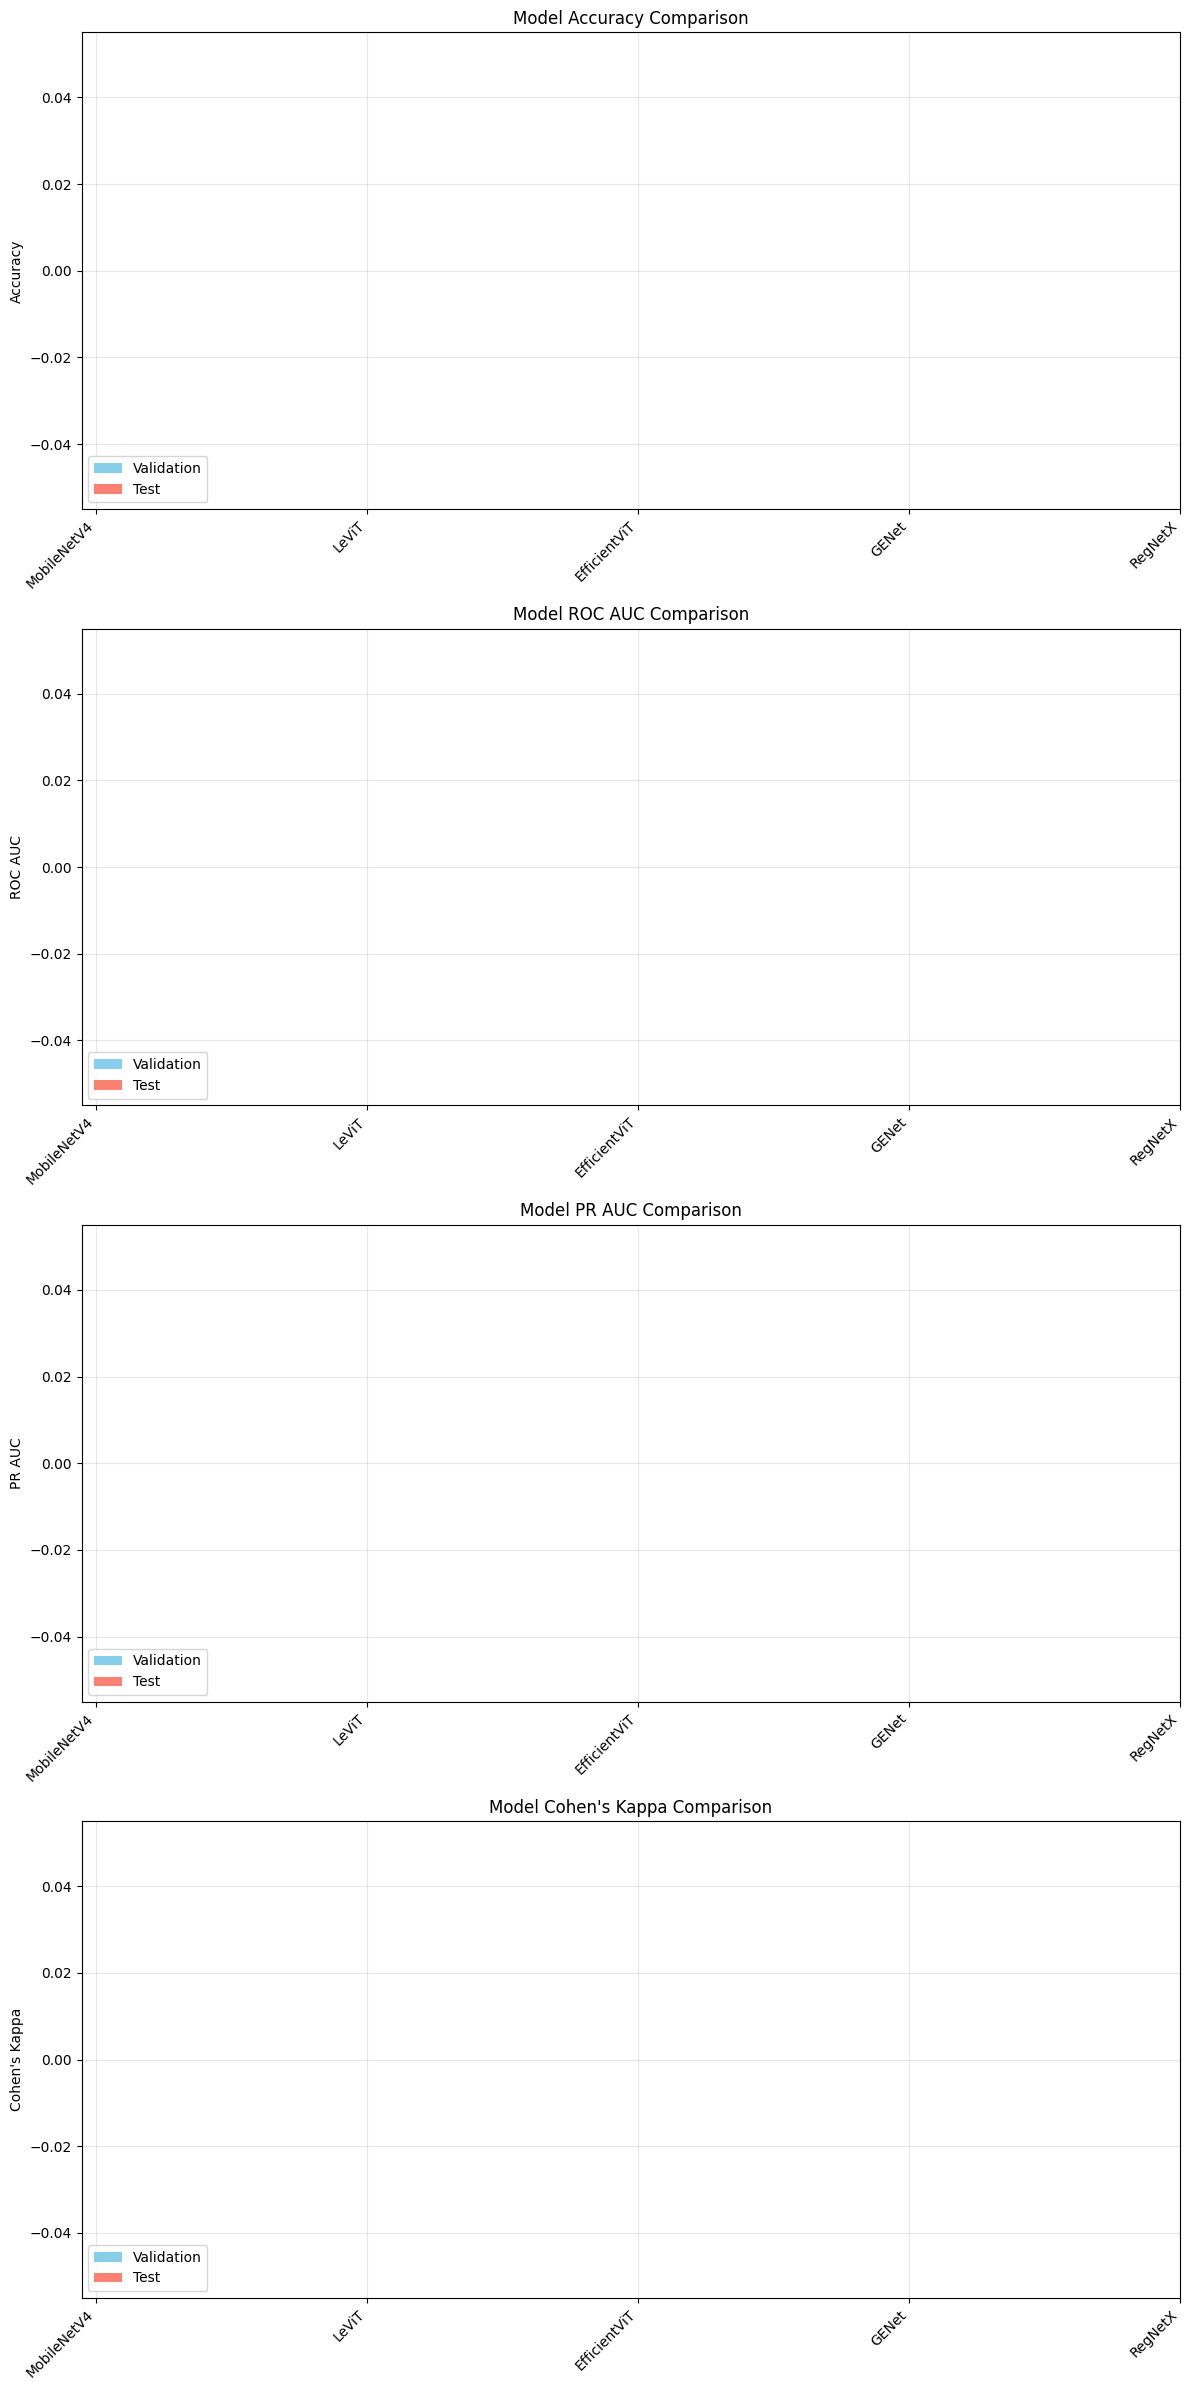

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


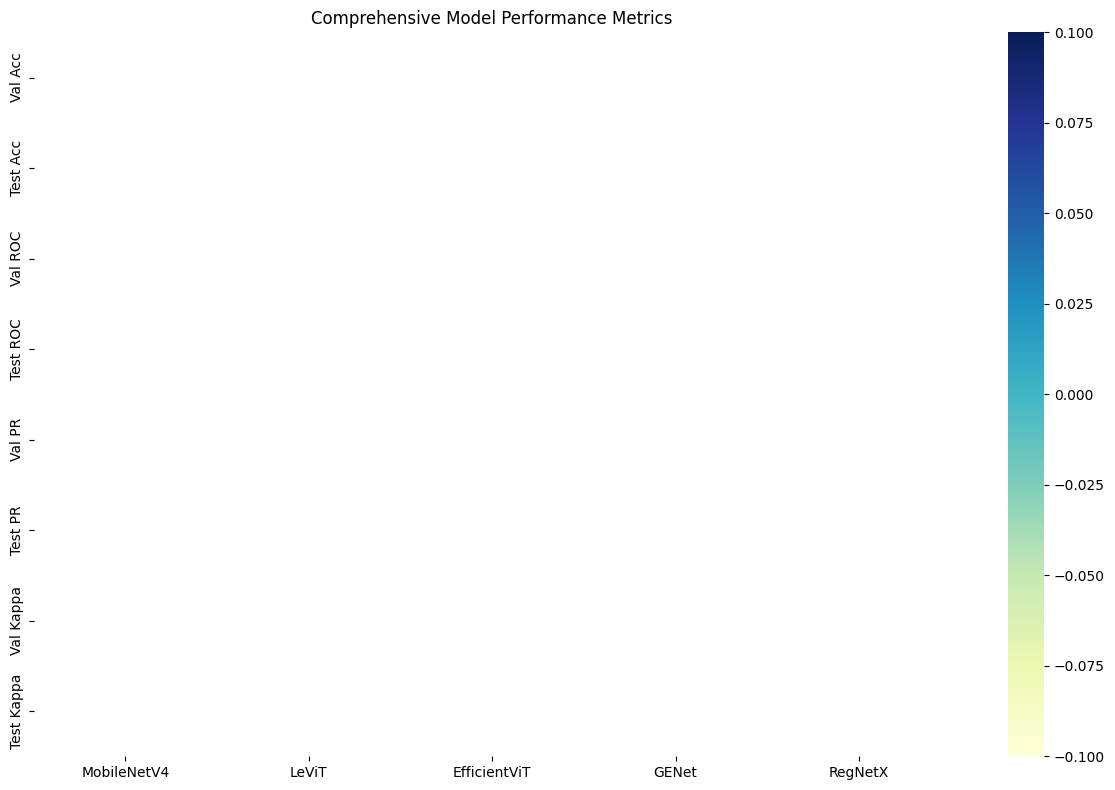

In [10]:
train_dir = '/kaggle/input/eye-disease-image-dataset/Augmented Dataset/Augmented Dataset'  # For training (pre-augmented data)
eval_dir = '/kaggle/input/eye-disease-image-dataset/Original Dataset/Original Dataset'  # For val and test
epochs = 15
classes_to_exclude = ["Pterygium"]
batch_size = 32

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Define transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

try:
    # Load datasets
    print(f"Loading training dataset from {train_dir}...")
    train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
    
    print(f"Loading evaluation dataset from {eval_dir}...")
    eval_dataset = datasets.ImageFolder(root=eval_dir, transform=transform)
    
    # Print dataset information
    print(f"Training dataset loaded with {len(train_dataset)} images across {len(train_dataset.classes)} classes.")
    print(f"Training classes: {train_dataset.classes}")
    
    print(f"Evaluation dataset loaded with {len(eval_dataset)} images across {len(eval_dataset.classes)} classes.")
    print(f"Evaluation classes: {eval_dataset.classes}")
    
    # Filter datasets if needed
    excluded_classes = classes_to_exclude or []
    if excluded_classes:
        print(f"Filtering out classes: {excluded_classes}")
        filtered_train_dataset = FilteredImageDataset(train_dataset, excluded_classes=excluded_classes)
        filtered_eval_dataset = FilteredImageDataset(eval_dataset, excluded_classes=excluded_classes)
    else:
        filtered_train_dataset = train_dataset
        filtered_eval_dataset = eval_dataset
    
    # Check if the filtered classes match between training and evaluation datasets
    if set(filtered_train_dataset.classes) != set(filtered_eval_dataset.classes):
        print("Warning: Class mismatch between filtered training and evaluation datasets!")
        print(f"Filtered training classes: {filtered_train_dataset.classes}")
        print(f"Filtered evaluation classes: {filtered_eval_dataset.classes}")
        
        # Find common classes
        common_classes = set(filtered_train_dataset.classes).intersection(set(filtered_eval_dataset.classes))
        print(f"Common classes: {common_classes}")
        
        # Create additional filtering based on common classes
        filtered_train_dataset = FilteredImageDataset(train_dataset, 
                                                   included_classes=common_classes)
        filtered_eval_dataset = FilteredImageDataset(eval_dataset, 
                                                  included_classes=common_classes)
    
    # Split evaluation dataset into validation and test sets
    eval_ratio = 0.7  # 70% validation, 30% test
    eval_size = len(filtered_eval_dataset)
    val_size = int(eval_ratio * eval_size)
    test_size = eval_size - val_size
    
    val_dataset, test_dataset = random_split(filtered_eval_dataset, [val_size, test_size])
    
    print(f"Training set size: {len(filtered_train_dataset)}")
    print(f"Validation set size: {len(val_dataset)}")
    print(f"Test set size: {len(test_dataset)}")
    
    # Create data loaders
    train_loader = DataLoader(filtered_train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    # Get the number of classes (after filtering)
    num_classes = len(filtered_train_dataset.classes)
    print(f"Number of classes after filtering: {num_classes}")
    print(f"Classes after filtering: {filtered_train_dataset.classes}")
    
    # Initialize models
    print("Initializing models...")
    
    # Initialize models with the updated number of classes
    all_models = {
        "MobileNetV4": get_model_mobilenetv4(num_classes, freeze_layers=True),
        "LeViT": get_model_levit(num_classes, freeze_layers=True),
        "EfficientViT": get_model_efficientvit(num_classes, freeze_layers=True),
        "GENet": get_model_gernet(num_classes, freeze_layers=True),
        "RegNetX": get_model_regnetx(num_classes, freeze_layers=True)
    }
    
    models = list(all_models.values())
    model_names = list(all_models.keys())
    
    # Train and compare models
    print("Starting model training and comparison...")
    compare_models(models, train_loader, val_loader, test_loader, filtered_train_dataset, epochs=epochs, names=model_names)
    
except Exception as e:
    print(f"Error in eye disease classification pipeline: {e}")
    import traceback
    traceback.print_exc()